# Testing CNN Shape Measurements of Simple Galaxy Models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Tensorflow version: {}".format(tf.version.VERSION))

#keras only after gpu ID and memory usage is set
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds
import autometacal as amc
import galsim
import tqdm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Tensorflow version: 2.7.0


## CNN Models

In [2]:
def Ribli19(imsize=50, n_target=2 ,n_channels=1, nf=64, reg = 5e-5,
          padding='same', gpu='0'):

    #input
    inp = kl.Input((imsize, imsize,n_channels))
    
    # conv block 1
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 2
    x = kl.Conv2D(2*nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 3
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 4
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 5
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (1, 1), padding=padding,  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    #  end of conv
    
    x = kl.GlobalAveragePooling2D()(x)    
    x = kl.Dense(n_target)(x)#, name = 'final_dense_n%d_ngpu%d' % (n_target, len(gpu.split(','))))(x)  

    model = km.Model(inputs=inp, outputs=x)  # make model
       
    return model
model = Ribli19(51,n_channels=1)

## Load Data

In [3]:
from autometacal.python.datasets import GalGen

In [4]:
batch_size=8
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=0.9*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=51, ny=51, scale=.2).array),axis=0)
gal_images,psf_images = onebatch['obs_image'],onebatch['psf_image'] 

plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

### Test with finitediff

In [6]:
@tf.function
def get_metacal_response_finitediff(gal_image,
                                    psf_image,
                                    reconv_psf_image,
                                    shear,
                                    step,
                                    method):
  """
  Gets shear response as a finite difference operation, 
  instead of automatic differentiation.
  """
  batch_size, _ , _ = gal_image.get_shape().as_list()
  step_batch = tf.constant(step,shape=(batch_size,1),dtype=tf.float32)
  
  step1p = tf.pad(step_batch,[[0,0],[0,1]])
  step1m = tf.pad(-step_batch,[[0,0],[0,1]])
  step2p = tf.pad(step_batch,[[0,0],[1,0]])
  step2m = tf.pad(-step_batch,[[0,0],[1,0]])
    
  img0s = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    [[0,0]]
  ) 
  
  shears1p = shear + step1p
  img1p = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears1p
  )
  
  shears1m = shear + step1m 
  img1m = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears1m
  ) 
  
  shears2p = shear + step2p 
  img2p = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears2p
  )
  
  shears2m = shear + step2m 
  img2m = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears2m
  ) 
  
  g0s = method(img0s)
  g1p = method(img1p)
  g1m = method(img1m)
  g2p = method(img2p)
  g2m = method(img2m)
  
  R11 = (g1p[:,0]-g1m[:,0])/(2*step)
  R21 = (g1p[:,1]-g1m[:,1])/(2*step) 
  R12 = (g2p[:,0]-g2m[:,0])/(2*step)
  R22 = (g2p[:,1]-g2m[:,1])/(2*step)
 
  #N. B.:The matrix is correct. 
  #The transposition will swap R12 with R21 across a batch correctly.
  R = tf.transpose(tf.convert_to_tensor(
    [[R11,R21],
     [R12,R22]],dtype=tf.float32)
  )
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 

  return ellip_dict, R

In [7]:
generate_mcal_image = amc.generate_mcal_image

In [8]:
get_metacal_response_finitediff(gal_images,
                                psf_images,
                                reconv_psf_image,
                                [0,0],0.01,model)[1]-amc.get_metacal_response_finitediff(gal_images,
                                                                                         psf_images,
                                   reconv_psf_image,0.01,model)[1]

<tf.Tensor: shape=(8, 2, 2), dtype=float32, numpy=
array([[[-1.39698386e-07, -1.39698386e-07],
        [ 4.01632860e-07, -3.55066732e-07]],

       [[ 2.32830644e-07,  4.65661287e-08],
        [ 4.07453626e-08, -1.10594556e-07]],

       [[ 6.98491931e-07, -3.72529030e-07],
        [-2.91038305e-07, -1.62981451e-07]],

       [[ 2.32830644e-07, -1.86264515e-07],
        [ 4.65661287e-08,  1.51339918e-07]],

       [[ 4.65661287e-07,  4.65661287e-07],
        [-1.10594556e-07,  1.10594556e-07]],

       [[ 5.12227416e-07,  4.65661287e-08],
        [ 6.40284270e-08,  1.16415322e-08]],

       [[-4.65661287e-08,  2.32830644e-08],
        [ 3.55066732e-07, -5.23868948e-08]],

       [[ 1.86264515e-07,  3.72529030e-07],
        [ 9.31322575e-08,  1.28056854e-07]]], dtype=float32)>

In [9]:
@tf.function
def loss(batch):
  
  shears = tf.random.uniform((batch_size,2),-.1,.1,dtype=tf.float32)
  #compute response
  R = get_metacal_response_finitediff(batch['obs_image'],
                                          batch['psf_image'],
                                          reconv_psf_image,
                                          shear=shears,
                                          step=0.01,
                                          method=model)[1]
  #R = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

In [11]:
@tf.function
def step():
  
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
       
    lost = loss(onebatch)
    

  grads = tape.gradient(lost, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return lost
  
    
opt = ko.SGD(learning_rate=0.005,nesterov=True)  

In [12]:
lost = []
for _ in tqdm.tqdm(range(4000)):
  batch = batchit.next()
  lost.append(step())

100%|██████████| 4000/4000 [06:01<00:00, 11.08it/s]


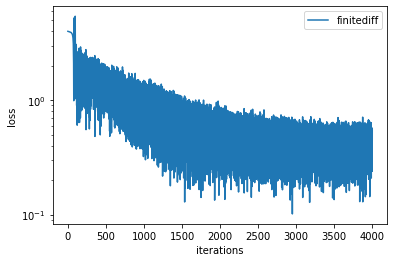

In [13]:
plt.plot(range(4000),lost,label='finitediff')
#plt.plot(range(4000),loistad,label='autodiff')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.savefig('learning4.png',bbox_inches='tight')

In [46]:
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.batch(128)
data = data.prefetch(tf.data.experimental.AUTOTUNE)
batchit = data.as_numpy_iterator()


In [47]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(10)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)
  

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [52]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [56]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

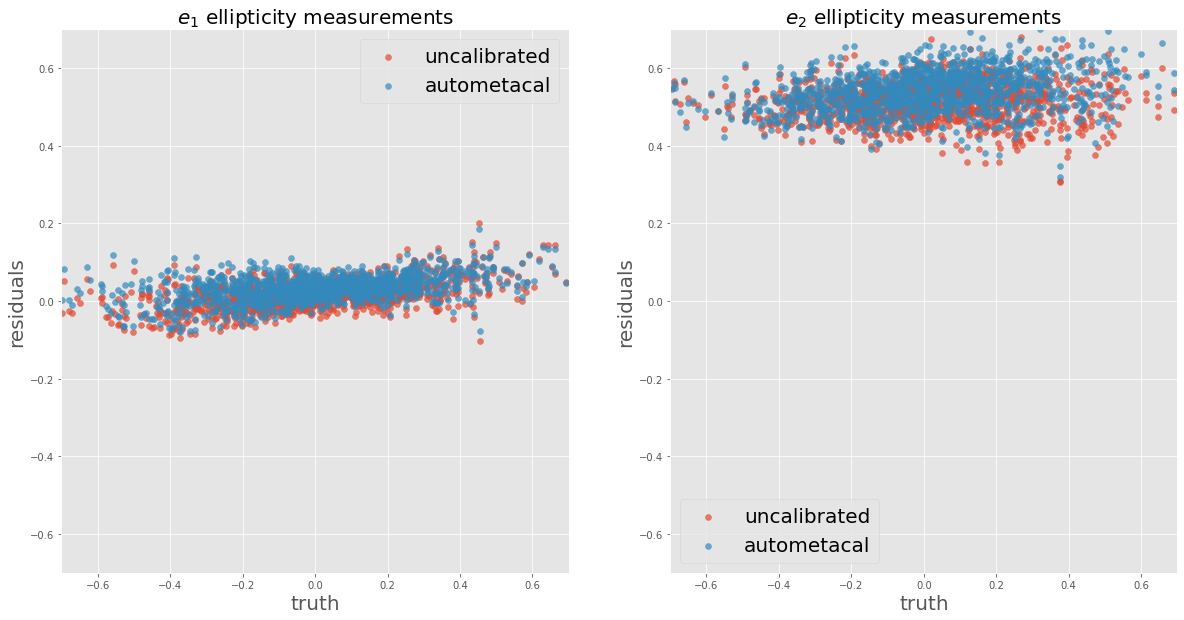

In [57]:
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.pdf",bbox_inches="tight")

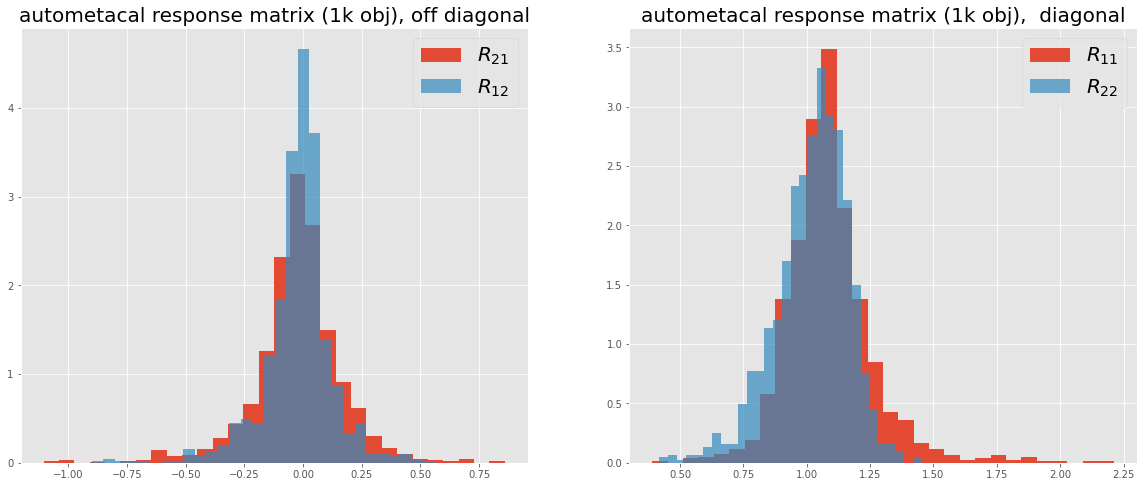

In [55]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution.pdf',bbox_inches='tight')

## Testing the trained model:

In [66]:
from scipy.stats import truncnorm
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
Ngal=200
while i<Ngal :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garray = np.array(g_list)


In [67]:
def make_data(N=1,
  snr = 80,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr)
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image.array)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [68]:
snr= 80
scale = 0.2
stamp_size = 51
psf_fwhm = 0.9
gal_hlr = 0.7

gal_images, psf_images = make_data(N=Ngal,
                                  snr = snr,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

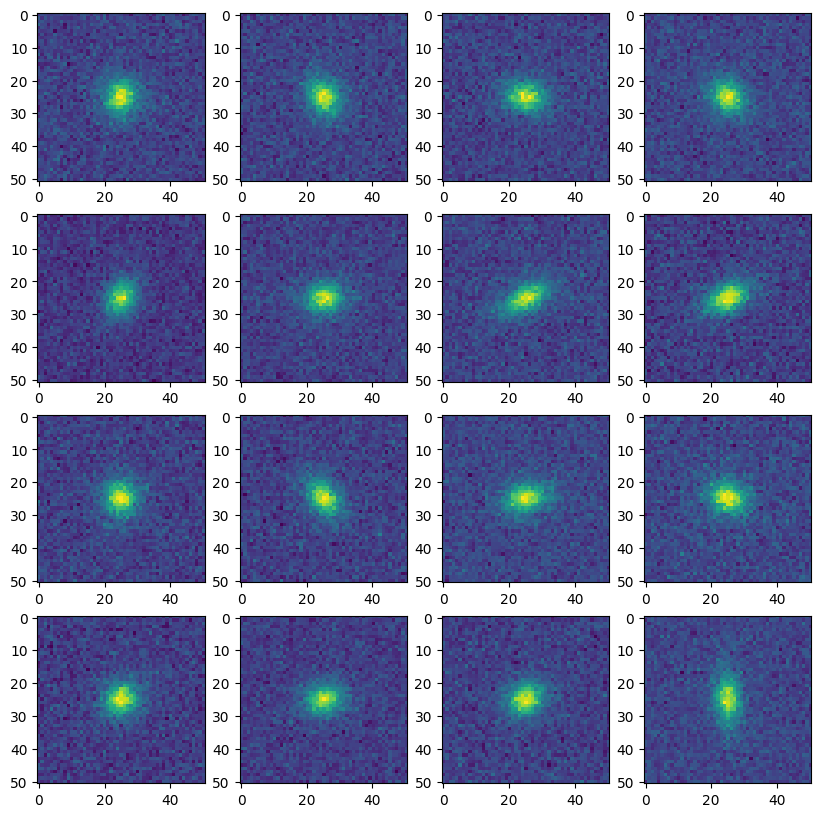

In [69]:
plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

In [70]:
e_auto, R_auto = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,model)
#calibre_f=np.mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [76]:
calibre_f=np.mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

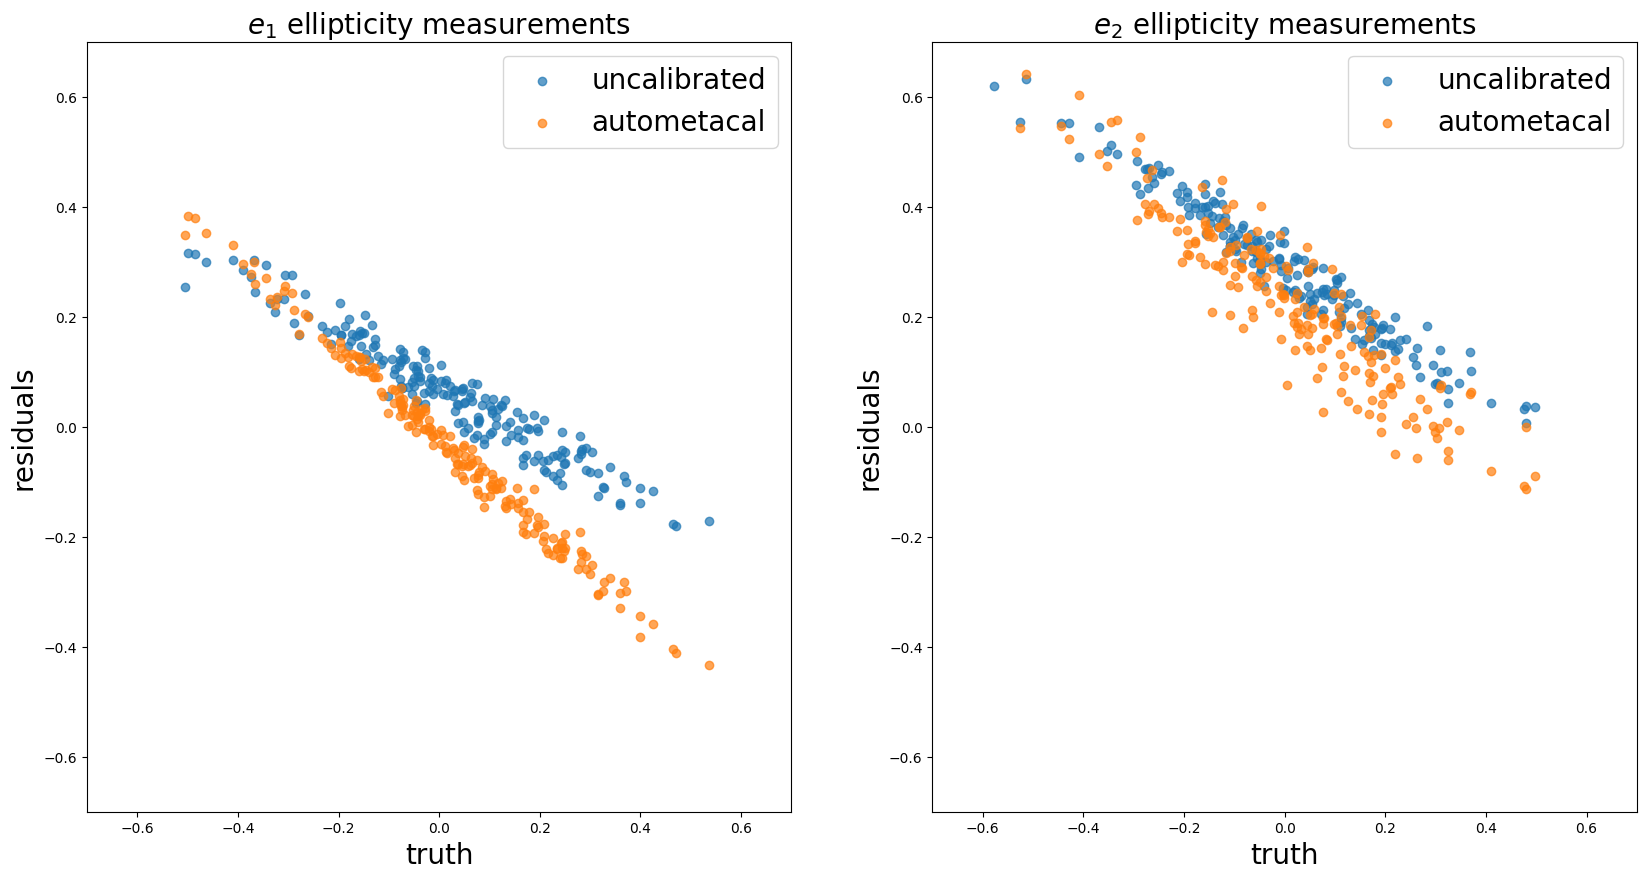

In [77]:
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.pdf",bbox_inches="tight")

In [19]:
banana();

NameError: name 'banana' is not defined